In [1]:
#!/usr/bin python3
import itertools
import json
import numpy as np
import pandas as pd
import random
from sklearn import metrics
import seaborn as sns
from tabulate import tabulate
import torch
import torch.backends.mps
from torch.utils.data import DataLoader

from utils import data_utils, data_loader, model_utils
from models import (avg_speed, basic_ff, basic_rnn, gru_rnn, persistent_speed, time_table)

import importlib

torch.set_default_dtype(torch.float)

run_folder = "../results/debug/"
network_folder = "kcm/"

if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

### Set run and hyperparameters
EPOCHS = 50
BATCH_SIZE = 512
LEARN_RATE = 1e-3
HIDDEN_SIZE = 32
NUM_WORKERS = 0

### Load train/test data
print("="*30)
data_folder = run_folder + network_folder + "deeptte_formatted/"
print(f"Loading data from '{data_folder}'...")
# Load config
with open(data_folder + "config.json", "r") as f:
    config = json.load(f)
# Load GTFS-RT samples
train_data_chunks, valid_data = data_utils.load_train_test_data(data_folder, config['n_folds']) # Validation data no longer used
# Load GTFS data
print(f"Loading and merging GTFS files from '{config['gtfs_folder']}'...")
gtfs_data = data_utils.merge_gtfs_files("."+config['gtfs_folder'])

Using device: cpu
Loading data from '../results/debug/kcm/deeptte_formatted/'...
Loading and merging GTFS files from './data/kcm_gtfs/2023_01_23/'...


In [2]:
fold_num = 0
importlib.reload(data_loader)
# Set aside the train/test data according to the current fold number
test_data = train_data_chunks[fold_num]
train_data = [x for i,x in enumerate(train_data_chunks) if i!=fold_num]
# Combine the training data to single object
train_data = list(itertools.chain.from_iterable(train_data))

# Construct dataloaders for Pytorch models
train_dataloader = data_loader.make_generic_dataloader(train_data, config, BATCH_SIZE, "basic", NUM_WORKERS)
test_dataloader = data_loader.make_generic_dataloader(test_data, config, BATCH_SIZE, "basic", NUM_WORKERS)
train_dataloader_seq = data_loader.make_generic_dataloader(train_data, config, BATCH_SIZE, "sequential", NUM_WORKERS)
test_dataloader_seq = data_loader.make_generic_dataloader(test_data, config, BATCH_SIZE, "sequential", NUM_WORKERS)
train_lens, train_mask = data_utils.get_seq_info(train_dataloader_seq)
test_lens, test_mask = data_utils.get_seq_info(test_dataloader_seq)

train_dataloader_seq_tt = data_loader.make_generic_dataloader(train_data, config, BATCH_SIZE, "sequential_tt", NUM_WORKERS)
test_dataloader_seq_tt = data_loader.make_generic_dataloader(test_data, config, BATCH_SIZE, "sequential_tt", NUM_WORKERS)
train_lens_tt, train_mask_tt = data_utils.get_seq_info(train_dataloader_seq_tt)
test_lens_tt, test_mask_tt = data_utils.get_seq_info(test_dataloader_seq_tt)
print(f"Successfully loaded {len(train_data)} training samples and {len(test_data)} testing samples.")

# Define embedded variables for nn models
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    },
    'driverID': {
        'vocab_size': config['n_unique_veh'],
        'embed_dims': 6
    },
    'tripID': {
        'vocab_size': config['n_unique_trip'],
        'embed_dims': 20
    }
}

Successfully loaded 10356 training samples and 2589 testing samples.


In [20]:
print(f"Training persistent speed model...")
persistent_seq_model = persistent_speed.PersistentSpeedSeqModel(config, 1.0)
persistent_seq_labels, persistent_seq_preds = persistent_seq_model.predict(test_dataloader_seq)

persistent_seq_preds_tt = data_utils.convert_speeds_to_tts(persistent_seq_preds, test_dataloader_seq, test_mask, config)
persistent_seq_labels_tt = data_utils.convert_speeds_to_tts(persistent_seq_labels, test_dataloader_seq, test_mask, config)

Training persistent speed model...


<Axes: ylabel='Count'>

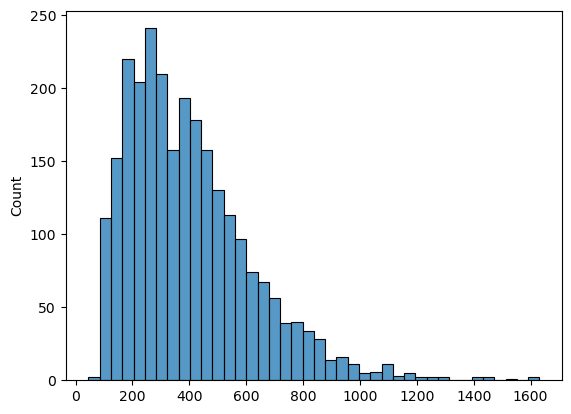

In [21]:
sns.histplot(persistent_seq_preds_tt)

<Axes: ylabel='Count'>

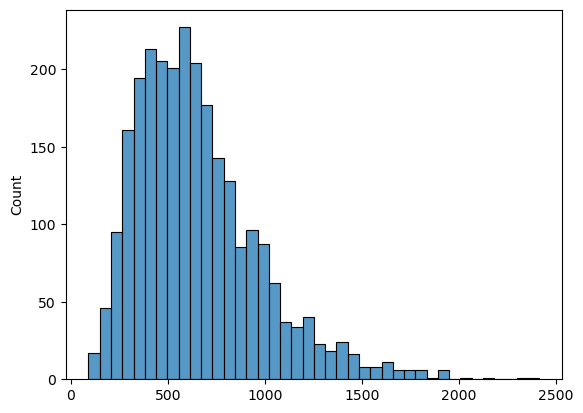

In [15]:
sns.histplot(persistent_seq_labels_tt)

In [ ]:
### Train RNN model
importlib.reload(gru_rnn)
print("="*30)
print(f"Training rnn model...")
rnn_model = gru_rnn.GRU_RNN(
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict
).to(device)
rnn_train_losses, rnn_test_losses = model_utils.fit_to_data(rnn_model, train_dataloader_seq_tt, test_dataloader_seq_tt, LEARN_RATE, EPOCHS, config, device, sequential_flag=True)
torch.save(rnn_model.state_dict(), run_folder + network_folder + f"models/rnn_model_{fold_num}.pt")
rnn_labels, rnn_preds, rnn_avg_loss = model_utils.predict(rnn_model, test_dataloader_seq_tt, device, sequential_flag=True)
rnn_labels = data_utils.de_normalize(rnn_labels, config['time_calc_s_mean'], config['time_calc_s_std'])
rnn_preds = data_utils.de_normalize(rnn_preds, config['time_calc_s_mean'], config['time_calc_s_std'])


In [ ]:
rnn_preds_masked = rnn_preds[test_mask_tt]
rnn_labels_masked = rnn_labels[test_mask_tt]

rnn_preds_tt = data_utils.aggregate_tts(rnn_preds, test_mask_tt)
rnn_labels_tt = data_utils.aggregate_tts(rnn_labels, test_mask_tt)

In [ ]:
metrics.mean_absolute_error(rnn_preds_tt, rnn_labels_tt)

In [ ]:
sns.histplot(rnn_preds_tt)

In [ ]:
sns.histplot(rnn_labels_tt)

In [ ]:
sns.histplot(rnn_preds_masked)

In [ ]:
sns.histplot(rnn_labels_masked)

In [ ]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(rnn_train_losses))],
        "Training Loss": rnn_train_losses,
        "Validation Loss": rnn_test_losses
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))

In [ ]:
# import torch
# from torch.profiler import profile, record_function, ProfilerActivity

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         preds, hidden_prev = rnn_model(inputs, hidden_prev)
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))